In [5]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost scipy


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('Dataset.csv')
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 Rows:")
df.head()

Shape: (64374, 12)

Data Types:
 CustomerID            int64
Age                   int64
Gender               object
Tenure                int64
Usage Frequency       int64
Support Calls         int64
Payment Delay         int64
Subscription Type    object
Contract Length      object
Total Spend           int64
Last Interaction      int64
Churn                 int64
dtype: object

First 5 Rows:


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [10]:
print("Statistical Summary:")
print(df.describe())
print("\nMissing Values:", df.isnull().sum().sum())
print("Duplicates:", df.duplicated().sum())
print("\nChurn Distribution:")
print(df['Churn'].value_counts())

Statistical Summary:
         CustomerID           Age        Tenure  Usage Frequency  \
count  64374.000000  64374.000000  64374.000000     64374.000000   
mean   32187.500000     41.970982     31.994827        15.080234   
std    18583.317451     13.924911     17.098234         8.816470   
min        1.000000     18.000000      1.000000         1.000000   
25%    16094.250000     30.000000     18.000000         7.000000   
50%    32187.500000     42.000000     33.000000        15.000000   
75%    48280.750000     54.000000     47.000000        23.000000   
max    64374.000000     65.000000     60.000000        30.000000   

       Support Calls  Payment Delay   Total Spend  Last Interaction  \
count   64374.000000   64374.000000  64374.000000      64374.000000   
mean        5.400690      17.133952    541.023379         15.498850   
std         3.114005       8.852211    260.874809          8.638436   
min         0.000000       0.000000    100.000000          1.000000   
25%        

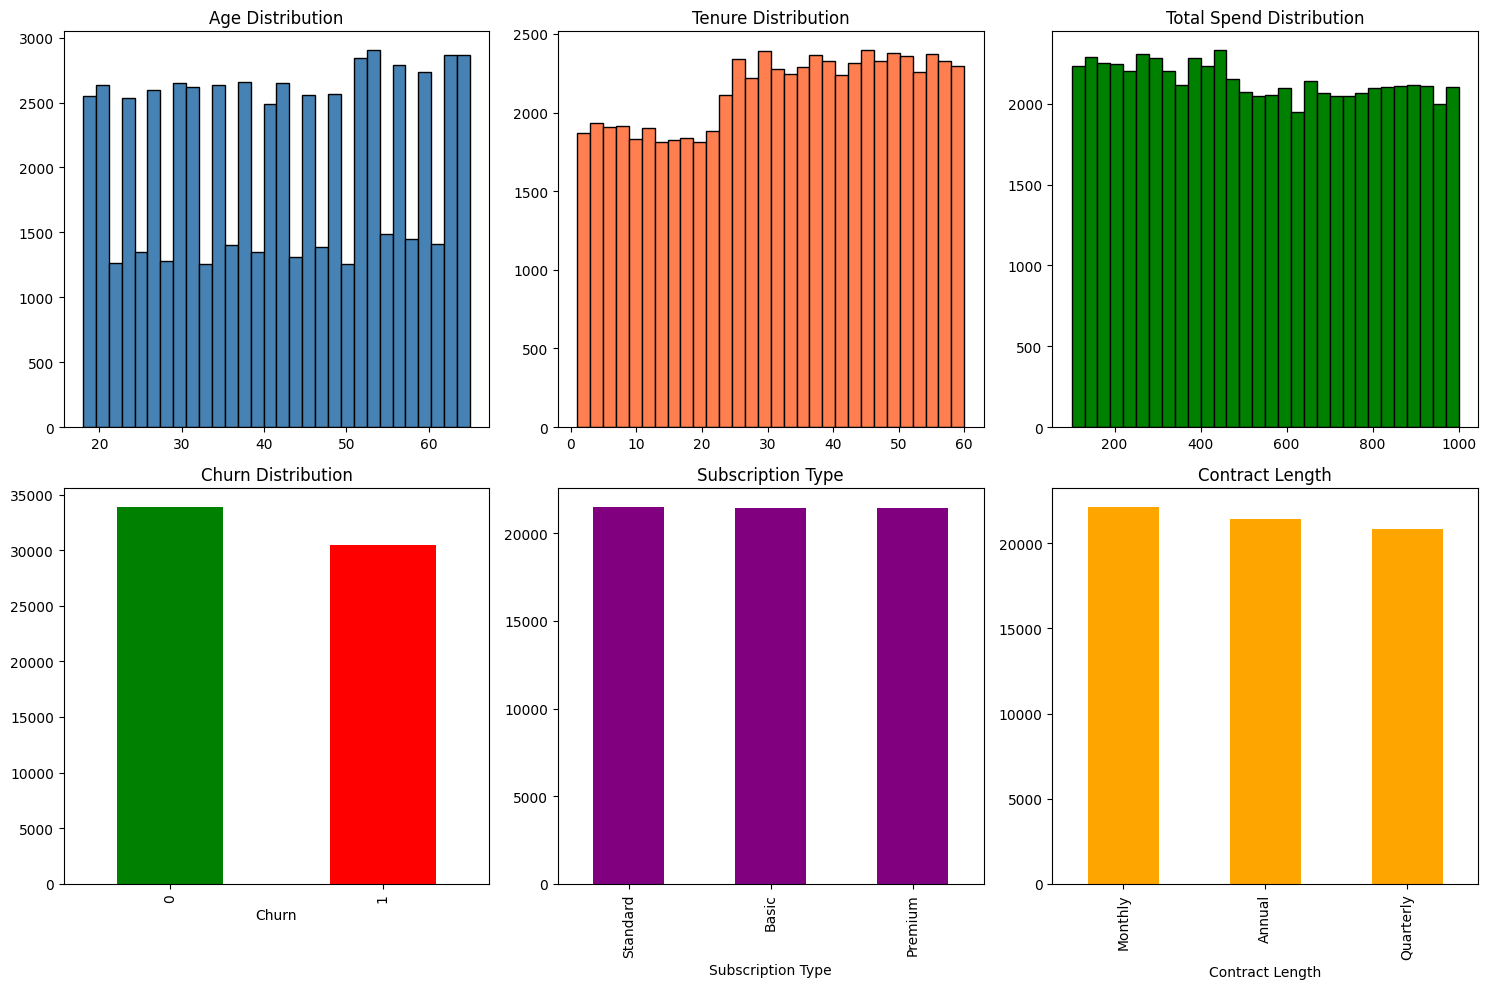

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].hist(df['Age'], bins=30, color='steelblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,1].hist(df['Tenure'], bins=30, color='coral', edgecolor='black')
axes[0,1].set_title('Tenure Distribution')
axes[0,2].hist(df['Total Spend'], bins=30, color='green', edgecolor='black')
axes[0,2].set_title('Total Spend Distribution')
df['Churn'].value_counts().plot(kind='bar', ax=axes[1,0], color=['green','red'])
axes[1,0].set_title('Churn Distribution')
df['Subscription Type'].value_counts().plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Subscription Type')
df['Contract Length'].value_counts().plot(kind='bar', ax=axes[1,2], color='orange')
axes[1,2].set_title('Contract Length')
plt.tight_layout()
plt.show()

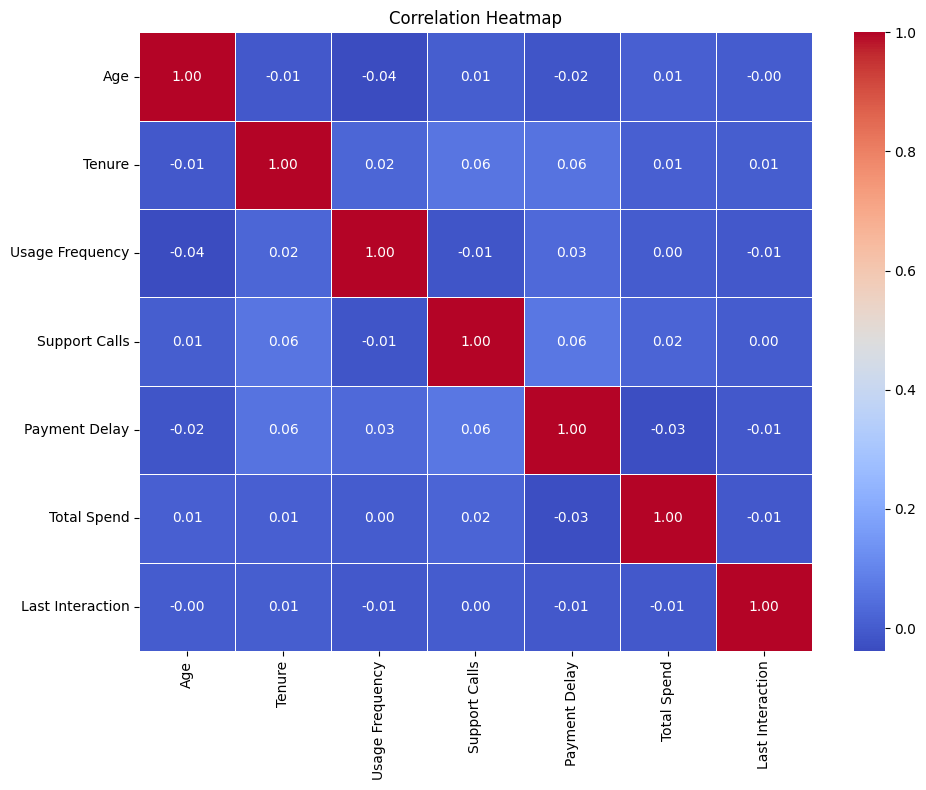

In [6]:
numerical_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

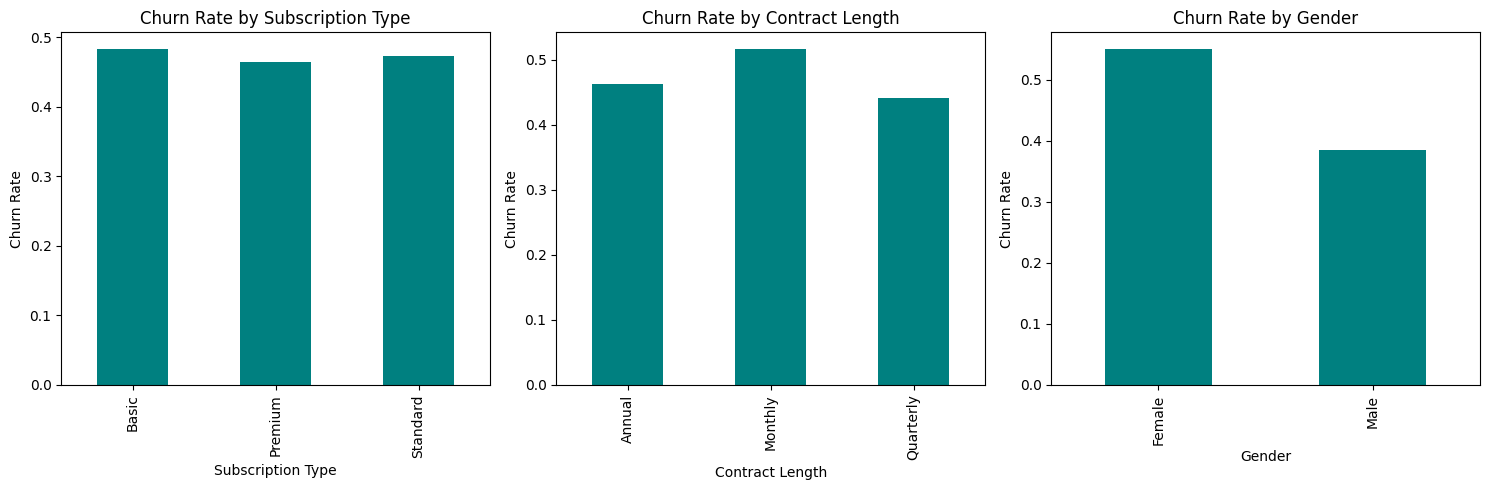

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['Subscription Type', 'Contract Length', 'Gender']):
    churn_rate = df.groupby(col)['Churn'].mean()
    churn_rate.plot(kind='bar', ax=axes[i], color='teal')
    axes[i].set_title(f'Churn Rate by {col}')
    axes[i].set_ylabel('Churn Rate')
plt.tight_layout()
plt.show()

In [8]:
df_clean = df.drop('CustomerID', axis=1).copy()
le_gender = LabelEncoder()
le_subscription = LabelEncoder()
le_contract = LabelEncoder()
df_clean['Gender'] = le_gender.fit_transform(df_clean['Gender'])
df_clean['Subscription Type'] = le_subscription.fit_transform(df_clean['Subscription Type'])
df_clean['Contract Length'] = le_contract.fit_transform(df_clean['Contract Length'])
print("Encoded Data:")
df_clean.head()

Encoded Data:


,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,0,25,14,4,27,0,1,598,9,1
1,41,0,28,28,7,13,2,1,584,20,0
2,47,1,27,10,2,29,1,0,757,21,0
3,35,1,9,12,5,17,1,2,232,18,0
4,53,0,58,24,9,2,2,0,533,18,0


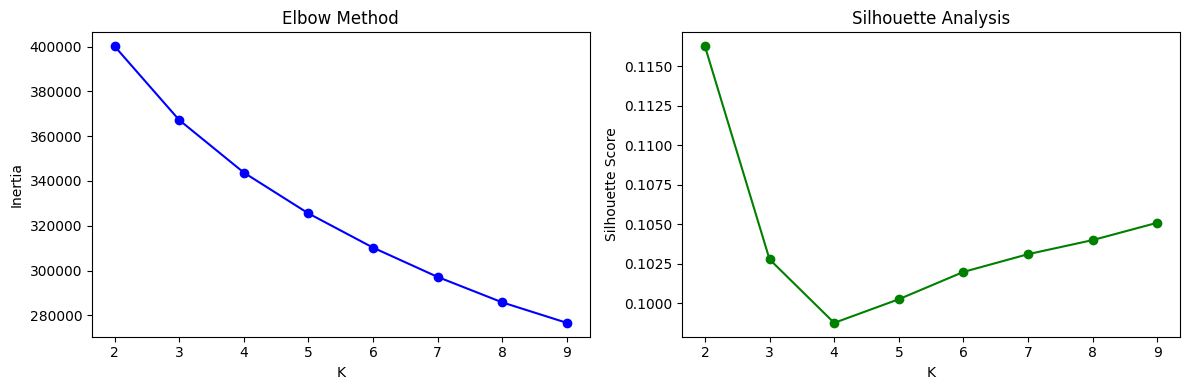

In [9]:
seg_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
X_seg = df_clean[seg_features]
scaler_seg = StandardScaler()
X_seg_scaled = scaler_seg.fit_transform(X_seg)

inertias = []
sil_scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_seg_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_seg_scaled, km.labels_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(range(2, 10), inertias, 'bo-')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[1].plot(range(2, 10), sil_scores, 'go-')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
plt.tight_layout()
plt.show()

K-Means Clustering Results:
Silhouette Score: 0.09877466662413194

Cluster Distribution:
Cluster
0    16548
1    16367
2    16864
3    14595
Name: count, dtype: int64


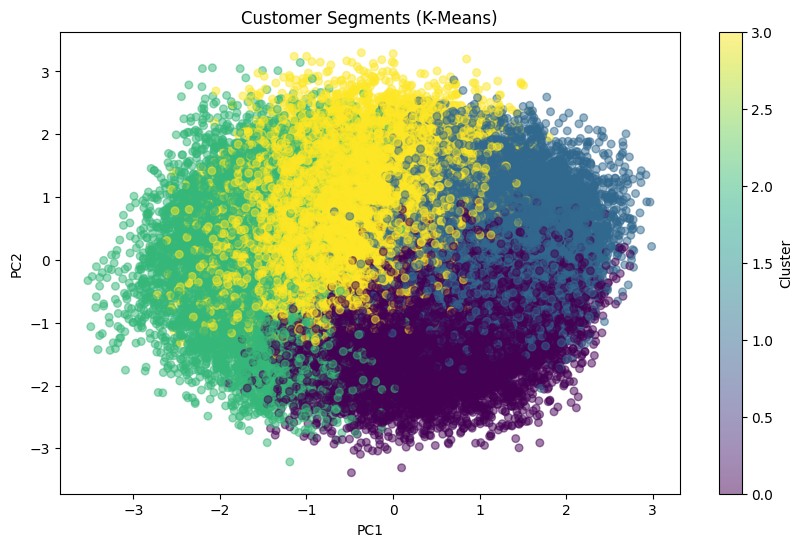

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_seg_scaled)
print("K-Means Clustering Results:")
print("Silhouette Score:", silhouette_score(X_seg_scaled, df_clean['Cluster']))
print("\nCluster Distribution:")
print(df_clean['Cluster'].value_counts().sort_index())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_seg_scaled)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Cluster'], cmap='viridis', alpha=0.5, s=30)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segments (K-Means)')
plt.show()

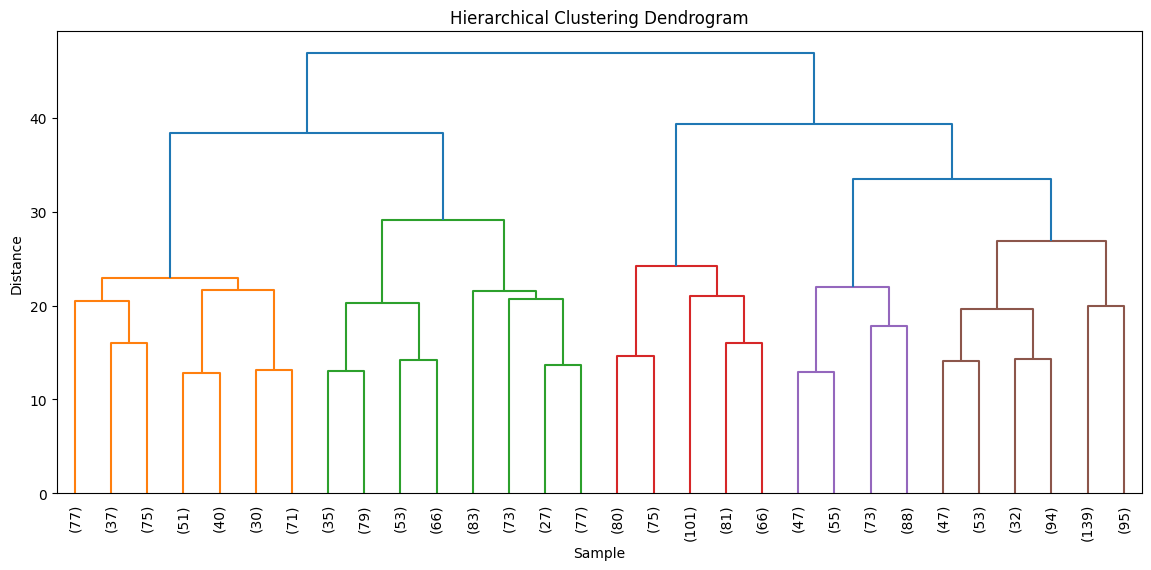

Hierarchical Clustering Silhouette Score (on sample): 0.0637648904502896


In [15]:
sample_idx = np.random.choice(len(X_seg_scaled), min(2000, len(X_seg_scaled)), replace=False)
X_sample = X_seg_scaled[sample_idx]
linked = linkage(X_sample, method='ward')
plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
hier_labels_sample = hierarchical.fit_predict(X_sample)
print("Hierarchical Clustering Silhouette Score (on sample):", silhouette_score(X_sample, hier_labels_sample))

df_clean['Hier_Cluster'] = df_clean['Cluster']

In [16]:
X = df_clean.drop(['Churn', 'Cluster', 'Hier_Cluster'], axis=1)
y = df_clean['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training Set Shape:", X_train_res.shape)
print("Class Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())

Training Set Shape: (54210, 10)
Class Distribution After SMOTE:
Churn
0    27105
1    27105
Name: count, dtype: int64


In [17]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_lr):.4f}")

Logistic Regression:
Accuracy: 0.8256
Precision: 0.8025
Recall: 0.8380
F1-Score: 0.8199
AUC-ROC: 0.9019


In [26]:
rf_params = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'min_samples_split': [10, 20], 'min_samples_leaf': [5, 10]}
rf = RandomForestClassifier(random_state=42, max_features='sqrt')
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_scaled)
y_prob_rf = rf_best.predict_proba(X_test_scaled)[:, 1]
print("Random Forest (Best Params:", rf_grid.best_params_, ")")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest (Best Params: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100} )
Accuracy: 0.9591
Precision: 0.9401
Recall: 0.9757
F1-Score: 0.9576
AUC-ROC: 0.9965


In [27]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, subsample=0.7, colsample_bytree=0.7, reg_alpha=1, reg_lambda=2, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("XGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

XGBoost:
Accuracy: 0.9584
Precision: 0.9378
Recall: 0.9769
F1-Score: 0.9570
AUC-ROC: 0.9955


Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.825553   0.802481 0.838006  0.819859 0.901925
      Random Forest  0.959068   0.940126 0.975734  0.957599 0.996457
            XGBoost  0.958369   0.937825 0.976881  0.956955 0.995547


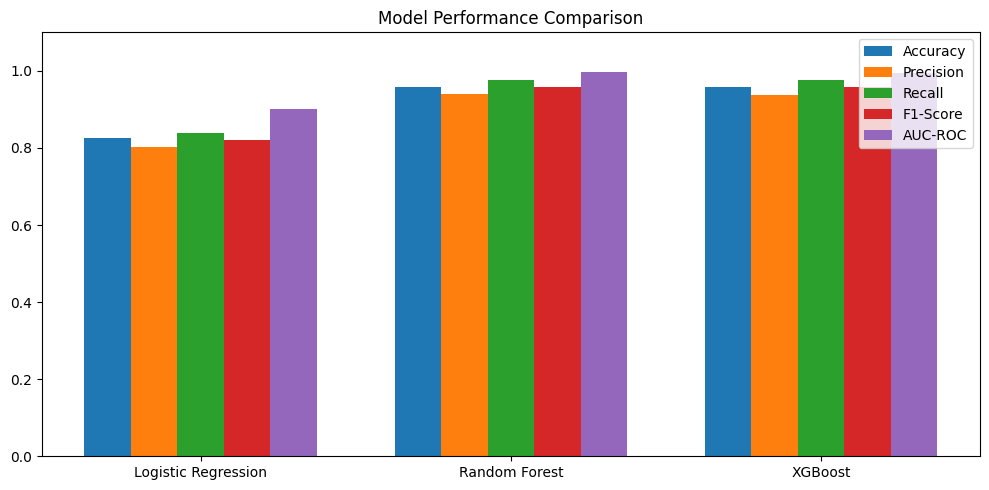

In [28]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_xgb)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)],
    'AUC-ROC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_xgb)]
})
print("Model Comparison:")
print(results.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.15
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']):
    ax.bar(x + i*width, results[metric], width, label=metric)
ax.set_xticks(x + width*2)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.set_title('Model Performance Comparison')
plt.tight_layout()
plt.show()

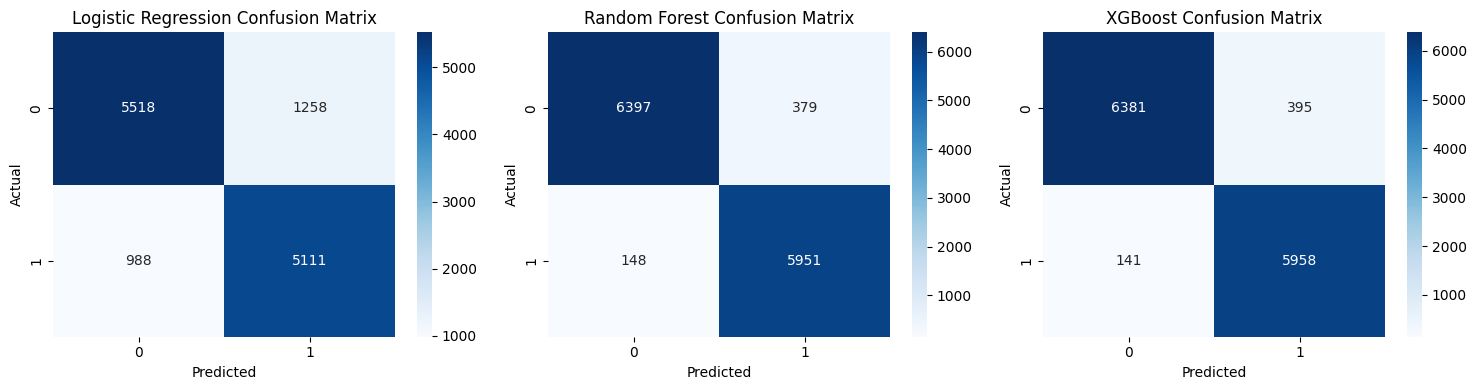

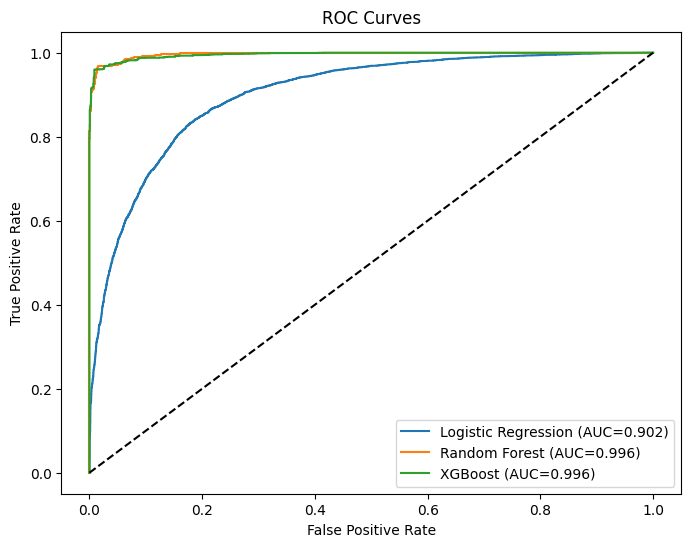

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (y_pred, title) in zip(axes, [(y_pred_lr, 'Logistic Regression'), (y_pred_rf, 'Random Forest'), (y_pred_xgb, 'XGBoost')]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for y_prob, label in [(y_prob_lr, 'Logistic Regression'), (y_prob_rf, 'Random Forest'), (y_prob_xgb, 'XGBoost')]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{label} (AUC={roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

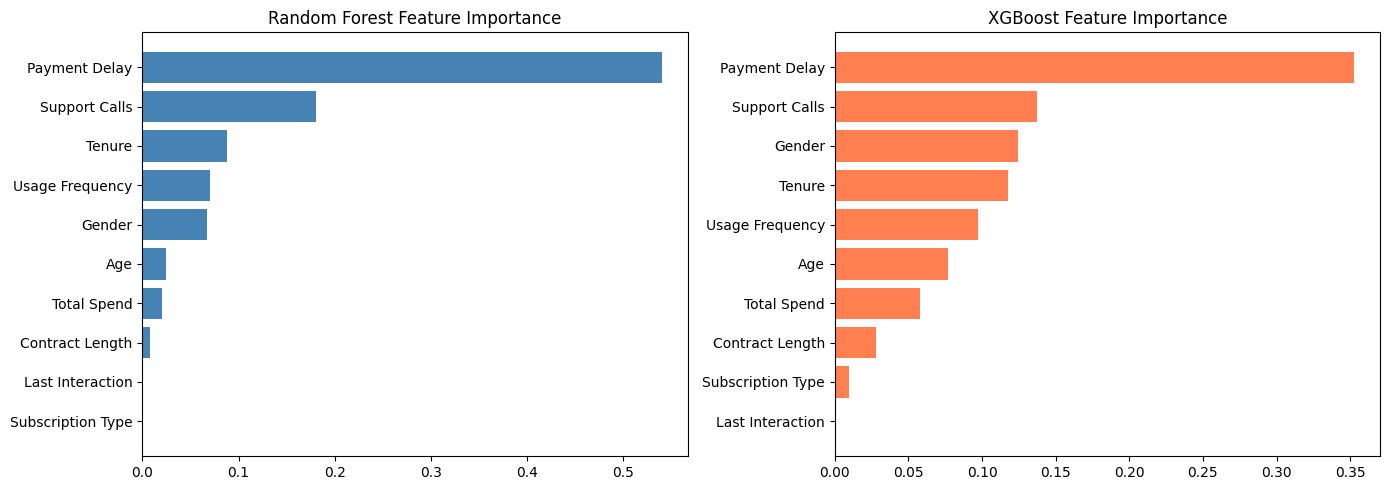

In [30]:
feature_names = X.columns.tolist()
rf_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_best.feature_importances_}).sort_values('Importance', ascending=False)
xgb_importance = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()
axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='coral')
axes[1].set_title('XGBoost Feature Importance')
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [31]:
print("=" * 70)
print("CUSTOMER CHURN PREDICTION - ACTUAL VS PREDICTED RESULTS")
print("=" * 70)

best_model = xgb_model
y_pred_best = y_pred_xgb
y_prob_best = y_prob_xgb

test_indices = y_test.index.tolist()
prediction_df = pd.DataFrame({
    'CustomerID': df.loc[test_indices, 'CustomerID'].values,
    'Age': df.loc[test_indices, 'Age'].values,
    'Tenure': df.loc[test_indices, 'Tenure'].values,
    'Subscription Type': df.loc[test_indices, 'Subscription Type'].values,
    'Total Spend': df.loc[test_indices, 'Total Spend'].values,
    'Actual Churn': y_test.values,
    'Predicted Churn': y_pred_best,
    'Churn Probability': y_prob_best
})

prediction_df['Actual Churn'] = prediction_df['Actual Churn'].map({0: 'Not Churned', 1: 'Churned'})
prediction_df['Predicted Churn'] = prediction_df['Predicted Churn'].map({0: 'Not Churned', 1: 'Churned'})
prediction_df['Churn Probability'] = prediction_df['Churn Probability'].round(4)

print("\nSample Predictions (First 20 Customers):")
print(prediction_df.head(20).to_string(index=False))

print("\n" + "=" * 70)
print("PREDICTION SUMMARY")
print("=" * 70)
print(f"Total Test Customers: {len(y_test)}")
print(f"Correctly Predicted: {(y_test.values == y_pred_best).sum()}")
print(f"Incorrectly Predicted: {(y_test.values != y_pred_best).sum()}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"\nActual Churned Customers: {(y_test == 1).sum()}")
print(f"Predicted Churned Customers: {(y_pred_best == 1).sum()}")
print(f"Correctly Identified Churners: {((y_test == 1) & (y_pred_best == 1)).sum()}")

CUSTOMER CHURN PREDICTION - ACTUAL VS PREDICTED RESULTS

Sample Predictions (First 20 Customers):
 CustomerID  Age  Tenure Subscription Type  Total Spend Actual Churn Predicted Churn  Churn Probability
       7438   26      51           Premium          761  Not Churned     Not Churned             0.0347
      54962   51       7             Basic          612      Churned         Churned             0.8256
      33686   52      23           Premium          937  Not Churned     Not Churned             0.0391
      20608   48      57          Standard          362  Not Churned     Not Churned             0.0346
      34099   41      45             Basic          675  Not Churned     Not Churned             0.0390
      25055   26      44             Basic          226  Not Churned     Not Churned             0.0213
      21915   20      45           Premium          606  Not Churned     Not Churned             0.0393
      42953   29       4          Standard          796  Not Churned  

In [32]:
print("=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)
print("\n1. CUSTOMER SEGMENTATION:")
print(f"   - K-Means Silhouette Score: {silhouette_score(X_seg_scaled, df_clean['Cluster']):.4f}")
print(f"   - Hierarchical Silhouette Score: {silhouette_score(X_seg_scaled, df_clean['Hier_Cluster']):.4f}")
print(f"   - Number of Customer Segments: 4")
print("\n2. CHURN PREDICTION (Best Model - XGBoost):")
print(f"   - Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"   - Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"   - Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"   - F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"   - AUC-ROC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("\n3. TOP 5 IMPORTANT FEATURES FOR CHURN:")
for i, row in xgb_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")
print("=" * 70)

FINAL PROJECT SUMMARY

1. CUSTOMER SEGMENTATION:
   - K-Means Silhouette Score: 0.0988
   - Hierarchical Silhouette Score: 0.0988
   - Number of Customer Segments: 4

2. CHURN PREDICTION (Best Model - XGBoost):
   - Accuracy: 0.9584
   - Precision: 0.9378
   - Recall: 0.9769
   - F1-Score: 0.9570
   - AUC-ROC: 0.9955

3. TOP 5 IMPORTANT FEATURES FOR CHURN:
   - Payment Delay: 0.3526
   - Support Calls: 0.1371
   - Gender: 0.1242
   - Tenure: 0.1179
   - Usage Frequency: 0.0970
